In [1]:
import os, json

from others.utils import read_airland_file, generate_separation_between_runways, save_solution
from models.MIP import solve_single_runway_mip, solve_multiple_runways_mip
from models.CP import solve_single_runway_cp, solve_multiple_runways_cp
from models.CP_MIP import solve_hybrid_lbbd
from ortools.sat.python import cp_model

In [2]:
data_dir = "data"
r_max = 5
num_files = 8
output_json = "results/metrics.json"
solutions_json = "results/solutions.json"

# Results

### Justificação para o report

**Dataset 9** represents a critical scalability threshold for the MIP formulation of the aircraft landing problem. With **100 aircraft** and a **large freeze-time (720)**, the model already exhibits a substantial increase in both the number of decision variables and constraints. This growth is mainly driven by the quadratic expansion of binary sequencing variables. From this dataset onward, the computational burden increases dramatically, clearly highlighting the practical limitations of exact MIP approaches for large-scale instances.

#### MIP Model Size per Dataset

| Dataset | Number of Aircraft | Decision Variables | Constraints | Estimated Runtime |
| ------: | -----------------: | -----------------: | ----------: | ----------------: |
|       9 |                100 |             10,200 |      12,019 |              Days |
|      10 |                150 |             22,800 |      25,569 |      Days / Weeks |
|      11 |                200 |             40,400 |      44,184 |    Weeks / Months |
|      12 |                250 |             63,000 |      67,977 |    Months / Years |
|      13 |                500 |            251,000 |     261,552 |       Impractical |

The computational results clearly show the exponential growth in complexity of the exact MIP formulation for the aircraft landing problem. While instances with up to 50 aircraft can be solved to optimality within seconds, doubling the number of aircraft to 100 already leads to solution times of several hours, especially under large freeze-time windows (e.g., 720). This behaviour is explained by the quadratic number of binary sequencing variables and the resulting exponential branch-and-bound search space. Based on empirical evidence and theoretical complexity, instances with 150 or more aircraft become computationally intractable for exact MIP solvers, with expected solution times ranging from days to months or even longer. Therefore, large-scale instances are unsuitable for exact optimization and must instead be addressed using time-limited approaches, heuristic methods, or alternative formulations.


## MIP

### Single Runway

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["MIP Single"] = []

for i in range(1, num_files + 1):
    file_name = f"airland{i}.txt"
    file_path = os.path.join(data_dir, file_name)

    print("\n" + "="*60)
    print(f"Processing file: {file_name}")
    print("="*60 + "\n")

    data = read_airland_file(file_path)

    solver, variables, metrics = solve_single_runway_mip(data['p'], data['planes'], data['separation_times'], hint=True, performance=True)

    save_solution(
        solver = solver,
        variables=variables,
        num_planes=data['p'],
        data=data['planes'],
        solution_file=solutions_json,
        tag="MIP Single",
        dataset_name=file_name
    )

    metrics_with_file = {"file": file_name, **metrics}
    all_metrics["MIP Single"].append(metrics_with_file)

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table:")
print("{:<12} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "File", "Exec Time(s)", "Variables", "Constraints", "Total Penalty", "B&B Nodes"
))
for m in all_metrics["MIP Single"]:
    print("{:<12} {:<15.4f} {:<15} {:<15} {:<15} {:<15}".format(
        m["file"], m["execution_time"], m["num_variables"],
        m["num_constraints"], m["total_penalty"], m["num_branch_and_bound_nodes"]
    ))



Processing file: airland1.txt

		Creating Single Runway MIP Model

-> Decision variables: 120
-> Constraints: 205

			Solving MIP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest
-------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00
    1 |       258.00 |   195.00 | 258.00 | 744.00
    2 |        98.00 |    89.00 |  98.00 | 510.00
    3 |       106.00 |    96.00 | 106.00 | 521.00
    4 |       118.00 |   110.00 | 123.00 | 555.00
    5 |       126.00 |   120.00 | 135.00 | 576.00
    6 |       134.00 |   124.00 | 138.00 | 577.00
    7 |       142.00 |   126.00 | 140.00 | 573.00
    8 |       150.00 |   135.00 | 150.00 | 591.00
    9 |       180.00 |   160.00 | 180.00 | 657.00

-> Planes that did not land on the target time:
Plane | Landing Time | Target | Early Dev | Late Dev | Penalty
--------------------------------------------------------------
    0 |       165.00 | 155.00 |      0.00 |    10.00 |  100.0

### Multiple Runways

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["MIP Multiple"] = []

for i in range(1, num_files + 1):
    file_name = f"airland{i}.txt"
    file_path = os.path.join(data_dir, file_name)

    print("\n" + "="*60)
    print(f"Processing file: {file_name}")
    print("="*60 + "\n")

    data = read_airland_file(file_path)

    for r in range(1, r_max + 1):
        print(f"\n---> Solving with {r} runways...\n")
        separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
        solver, variables, metrics = solve_multiple_runways_mip(data['p'], r, data['planes'], data['separation_times'], separation_times_between_runways,
                                                   hint=True, performance=True)

        penalty = metrics["total_penalty"]
        print(f"Runways={r} -> Total Penalty={penalty}")

        save_solution(
            solver = solver,
            variables=variables,
            num_planes=data['p'],
            data=data['planes'],
            solution_file=solutions_json,
            tag="MIP Multiple",
            dataset_name=file_name,
            num_runways=r
        )

        metrics_with_file = {"file": file_name, "num_runways": r, **metrics}
        all_metrics["MIP Multiple"].append(metrics_with_file)

        # Interrupt if zero penalty is found
        if penalty == 0:
            break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (MIP Multiple):")
header = "{:<12} {:<18} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "File", "Number of Runways", "Exec Time(s)", "Variables", "Constraints", "Total Penalty", "B&B Nodes"
)
print(header)
print("-" * len(header))

for m in all_metrics["MIP Multiple"]:
    print("{:<12} {:<18} {:<15.4f} {:<15} {:<15} {:<15} {:<15}".format(
        m["file"], m["num_runways"], m["execution_time"], m["num_variables"],
        m["num_constraints"], m["total_penalty"], m["num_branch_and_bound_nodes"]
    ))



Processing file: airland1.txt


---> Solving with 1 runways...

		Creating Multiple Runways MIP Solver

-> Decision variables: 220
-> Constraints: 395

			Solving MIP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest | Runway
----------------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00 |      0
    1 |       258.00 |   195.00 | 258.00 | 744.00 |      0
    2 |        98.00 |    89.00 |  98.00 | 510.00 |      0
    3 |       106.00 |    96.00 | 106.00 | 521.00 |      0
    4 |       118.00 |   110.00 | 123.00 | 555.00 |      0
    5 |       126.00 |   120.00 | 135.00 | 576.00 |      0
    6 |       134.00 |   124.00 | 138.00 | 577.00 |      0
    7 |       142.00 |   126.00 | 140.00 | 573.00 |      0
    8 |       150.00 |   135.00 | 150.00 | 591.00 |      0
    9 |       180.00 |   160.00 | 180.00 | 657.00 |      0

-> Planes that did not land on the target time:
Plane | Landing Time | Target | Early Dev 

### Large Datasets

In [6]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["MIP Multiple Large Datasets"] = []

# Values of runways to test for each dataset, based on prior knowledge
runways = {'9': [3,4], '10': [4,5], '11': [5], '12': [6], '13': [7]}

for i in range(9, 14):
    file_name = f"airland{i}.txt"
    file_path = os.path.join(data_dir, file_name)

    print("\n" + "="*60)
    print(f"Processing file: {file_name}")
    print("="*60 + "\n")

    data = read_airland_file(file_path)

    for r in runways[str(i)]:
        print(f"\n---> Solving with {r} runways...\n")
        separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
        solver, variables, metrics = solve_multiple_runways_mip(data['p'], r, data['planes'], data['separation_times'], separation_times_between_runways,
                                                   hint=True, performance=True)

        penalty = metrics["total_penalty"]
        print(f"Runways={r} -> Total Penalty={abs(penalty):.2f}")

        save_solution(
            solver = solver,
            variables=variables,
            num_planes=data['p'],
            data=data['planes'],
            solution_file=solutions_json,
            tag="MIP Multiple Large Datasets",
            dataset_name=file_name,
            num_runways=r
        )

        metrics_with_file = {"file": file_name, "num_runways": r, **metrics}
        all_metrics["MIP Multiple Large Datasets"].append(metrics_with_file)

        # Interrupt if zero penalty is found
        if penalty == 0:
            break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (MIP Multiple Large Datasets):")
header = "{:<12} {:<18} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "File", "Number of Runways", "Exec Time(s)", "Variables", "Constraints", "Total Penalty", "B&B Nodes"
)
print(header)
print("-" * len(header))

for m in all_metrics["MIP Multiple Large Datasets"]:
    print("{:<12} {:<18} {:<15.4f} {:<15} {:<15} {:<15} {:<15}".format(
        m["file"], m["num_runways"], m["execution_time"], m["num_variables"],
        m["num_constraints"], abs(m["total_penalty"]), m["num_branch_and_bound_nodes"]
    ))



Processing file: airland9.txt


---> Solving with 3 runways...

		Creating Multiple Runways MIP Solver

-> Decision variables: 20400
-> Constraints: 34643

			Solving MIP

-> Landing times of all planes:
Plane | Landing Time | Earliest |   Target |   Latest | Runway
--------------------------------------------------------------
    0 |       908.00 |   601.00 |   908.00 |  2401.00 |      0
    1 |      1027.00 |   725.00 |  1027.00 |  2525.00 |      2
    2 |      1378.00 |   928.00 |  1378.00 |  2728.00 |      2
    3 |      1502.00 |   974.00 |  1502.00 |  2774.00 |      0
    4 |      1618.00 |  1056.00 |  1618.00 |  2856.00 |      2
    5 |      1235.00 |  1119.00 |  1235.00 |  2919.00 |      2
    6 |      1520.00 |  1148.00 |  1520.00 |  2948.00 |      2
    7 |      1401.00 |  1195.00 |  1401.00 |  2995.00 |      1
    8 |      1584.00 |  1201.00 |  1584.00 |  3001.00 |      1
    9 |      1343.00 |  1218.00 |  1343.00 |  3018.00 |      0
   10 |      1787.00 |  1224.00 |  1787

## CP

### Single Runway

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["CP Single"] = []

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"CP Single - Strategy {name}"

    for i in range(1, num_files + 1):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        solver, model, variables, metrics = solve_single_runway_cp(
            data['p'], data['planes'], data['separation_times'], hint=True, search_strategy=strategy, performance=True)

        save_solution(
            solver = solver,
            variables=variables,
            num_planes=data['p'],
            data=data['planes'],
            solution_file=solutions_json,
            tag = tag,
            dataset_name=file_name
        )

        metrics_with_file = {"file": file_name, "strategy": name, **metrics}
        all_metrics["CP Single"].append(metrics_with_file)

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (CP Single):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Strategy", "Exec Time(s)", "Memory Usage", "Status", "Conflicts", "Branches", "Booleans", "Best Objective Bound", "Variables", "Constraints"
))
for m in all_metrics["CP Single"]:
    print("{:<12} {:<18} {:<18.4f} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["strategy"], m["execution_time"], m["memory_usage"],
        m["solution_status"], m["num_conflicts"], m["num_branches"],
        m["num_booleans"], m["best_objective_bound"], m["num_variables"], m["num_constraints"]
    ))


=== Testing strategy: Automatic Search ===


Processing file: airland1.txt

		     Creating CP model

-> Number of decision variables created: 75
-> Number of constraints: 130

			Solving CP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest
-------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00
    1 |       258.00 |   195.00 | 258.00 | 744.00
    2 |        98.00 |    89.00 |  98.00 | 510.00
    3 |       106.00 |    96.00 | 106.00 | 521.00
    4 |       118.00 |   110.00 | 123.00 | 555.00
    5 |       126.00 |   120.00 | 135.00 | 576.00
    6 |       134.00 |   124.00 | 138.00 | 577.00
    7 |       142.00 |   126.00 | 140.00 | 573.00
    8 |       150.00 |   135.00 | 150.00 | 591.00
    9 |       180.00 |   160.00 | 180.00 | 657.00

-> Planes that did not land on the target time:
Plane | Landing Time | Target | Early Dev | Late Dev | Penalty
--------------------------------------------------------------


### Multiple Runway

In [4]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["CP Multiple"] = []

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"CP Multiple - Strategy {name}"

    for i in range(1, num_files + 1):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in range(1, r_max + 1):
            print(f"\n---> Solving with {r} runways...\n")
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, variables, metrics = solve_multiple_runways_cp(data['p'], r, data['planes'], data['separation_times'],
                                                                separation_times_between_runways, hint=True, search_strategy=strategy, performance=True)

            penalty = metrics["best_objective_bound"]
            print(f"Runways={r} -> Best Objective Bound={penalty}")

            save_solution(
                solver = solver,
                variables=variables,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["CP Multiple"].append(metrics_with_file)

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (CP Multiple):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Strategy", "Num_runways", "Exec Time(s)", "Memory Usage", "Status", "Conflicts", "Branches", "Booleans", "Best Obj. Bound", "Variables", "Constraints"
))
for m in all_metrics["CP Multiple"]:
    print("{:<12} {:<18} {:<18.4f} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["strategy"], m["num_runways"], m["execution_time"], m["memory_usage"],
        m["solution_status"], m["num_conflicts"], m["num_branches"],
        m["num_booleans"], m["best_objective_bound"], m["num_variables"], m["num_constraints"]
    ))


=== Testing strategy: Automatic Search ===


Processing file: airland1.txt


---> Solving with 1 runways...

		     Creating CP model

-> Number of decision variables created: 130
-> Number of constraints: 320

			Solving CP

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest | Runway
----------------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00 |      0
    1 |       258.00 |   195.00 | 258.00 | 744.00 |      0
    2 |        98.00 |    89.00 |  98.00 | 510.00 |      0
    3 |       106.00 |    96.00 | 106.00 | 521.00 |      0
    4 |       118.00 |   110.00 | 123.00 | 555.00 |      0
    5 |       126.00 |   120.00 | 135.00 | 576.00 |      0
    6 |       134.00 |   124.00 | 138.00 | 577.00 |      0
    7 |       142.00 |   126.00 | 140.00 | 573.00 |      0
    8 |       150.00 |   135.00 | 150.00 | 591.00 |      0
    9 |       180.00 |   160.00 | 180.00 | 657.00 |      0

-> Planes that did not land on t

### Large Datasets

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["CP Multiple Large Datasets"] = []

# Values of runways to test for each dataset, based on prior knowledge
runways = {'9': [3,4], '10': [4,5], '11': [5], '12': [6], '13': [7]}

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"CP Multiple Large Datasets - Strategy {name}"

    for i in range(9, 14):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in runways[str(i)]:
            print(f"\n---> Solving with {r} runways...\n")
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, variables, metrics = solve_multiple_runways_cp(data['p'], r, data['planes'], data['separation_times'], separation_times_between_runways,
                                                    hint=True, search_strategy=strategy, performance=True)

            penalty = metrics["best_objective_bound"]
            print(f"Runways={r} -> Best Objective Bound={abs(penalty):.2f}")

            save_solution(
                solver = solver,
                variables=variables,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["CP Multiple Large Datasets"].append(metrics_with_file)

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (CP Multiple Large Datasets):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Strategy", "Num_runways", "Exec Time(s)", "Memory Usage", "Status", "Conflicts", "Branches", "Booleans", "Best Obj. Bound", "Variables", "Constraints"
))
for m in all_metrics["CP Multiple Large Datasets"]:
    print("{:<12} {:<18} {:<18.4f} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18.2f} {:<18.2f}".format(
        m["file"], m["strategy"], m["num_runways"], m["execution_time"], m["memory_usage"],
        m["solution_status"], m["num_conflicts"], m["num_branches"],
        m["num_booleans"], m["best_objective_bound"], m["num_variables"], m["num_constraints"]
    ))



=== Testing strategy: Automatic Search ===


Processing file: airland9.txt


---> Solving with 3 runways...

		     Creating CP model

-> Number of decision variables created: 10300
-> Number of constraints: 15962

			Solving CP

-> Landing times of all planes:
Plane | Landing Time | Earliest |   Target |   Latest | Runway
--------------------------------------------------------------
    0 |       908.00 |   601.00 |   908.00 |  2401.00 |      2
    1 |      1027.00 |   725.00 |  1027.00 |  2525.00 |      2
    2 |      1378.00 |   928.00 |  1378.00 |  2728.00 |      0
    3 |      1502.00 |   974.00 |  1502.00 |  2774.00 |      1
    4 |      1618.00 |  1056.00 |  1618.00 |  2856.00 |      2
    5 |      1235.00 |  1119.00 |  1235.00 |  2919.00 |      2
    6 |      1520.00 |  1148.00 |  1520.00 |  2948.00 |      2
    7 |      1401.00 |  1195.00 |  1401.00 |  2995.00 |      2
    8 |      1584.00 |  1201.00 |  1584.00 |  3001.00 |      0
    9 |      1343.00 |  1218.00 |  1343.00 |

## Hybrid CP-MIP

In [5]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["Hybrid"] = []

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"Hybrid - Strategy {name}"

    for i in range(1, num_files + 1):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in range(1, r_max + 1):
            print(f"\n---> Solving with {r} runways...\n")
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, fixed_runways, sp_times, metrics = solve_hybrid_lbbd(data['p'], r, data['planes'], data['separation_times'],
                                                                separation_times_between_runways, max_iterations=50, search_strategy=strategy, performance=True)

            penalty = metrics["total_best_objective_bound"]
            print(f"Runways={r} -> Total Penalty={penalty}")

            save_solution(
                solver = None,
                variables=None,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r,
                landing_times_override=sp_times,
                fixed_runways=fixed_runways
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["Hybrid"].append(metrics_with_file)

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (Hybrid):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Best Obj. Bound", "Strategy", "Num_runways", "Iterations", "Converged", "Exec Time(s)", "CP Time(s)", "MIP Time(s)", "MIP Calls", "Branches", "Conflicts", "Booleans", "Variables", "Constraints", "Memory Usage (MB)"
))
for m in all_metrics["Hybrid"]:
    print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["total_best_objective_bound"], m["strategy"], m["num_runways"], m["num_iterations"], m["converged"], m["total_time"],
        m["cp_time"], m["mip_time"], m["mip_num_calls"], m["cp_num_branches"], m["cp_num_conflicts"],
        m["cp_num_booleans"], m["cp_num_variables"], m["cp_num_constraints"], m["memory_start_MB"]
    ))


=== Testing strategy: Automatic Search ===


Processing file: airland1.txt


---> Solving with 1 runways...


		Running Hybrid LBBD Solver (Strengthened Master)

--- Iteration 1 ---
  >> Master Theta: 700 | Subproblem Real Cost: 701
  >> Gap found. Adding Optimality Cut.
--- Iteration 2 ---
  >> Master Theta: 700 | Subproblem Real Cost: 700

*** CONVERGENCE ACHIEVED in 2 iterations! ***

-> Landing times of all planes:
Plane | Landing Time | Earliest | Target | Latest | Runway
----------------------------------------------------------
    0 |       165.00 |   129.00 | 155.00 | 559.00 |      1
    1 |       258.00 |   195.00 | 258.00 | 744.00 |      1
    2 |        98.00 |    89.00 |  98.00 | 510.00 |      1
    3 |       106.00 |    96.00 | 106.00 | 521.00 |      1
    4 |       118.00 |   110.00 | 123.00 | 555.00 |      1
    5 |       126.00 |   120.00 | 135.00 | 576.00 |      1
    6 |       134.00 |   124.00 | 138.00 | 577.00 |      1
    7 |       142.00 |   126.00 | 140.00 | 57

### Large Datasets

In [3]:
if os.path.exists(output_json):
    with open(output_json, "r") as f:
        all_metrics = json.load(f)
else:
    all_metrics = {}

all_metrics["Hybrid Large Datasets"] = []

# Values of runways to test for each dataset, based on prior knowledge
runways = {'9': [3,4], '10': [4,5], '11': [5], '12': [6], '13': [7]}

strategies = {
    "Automatic Search": cp_model.AUTOMATIC_SEARCH,
    "Fixed Search": cp_model.FIXED_SEARCH,
    "Portfolio Search": cp_model.PORTFOLIO_SEARCH,
    "LP Search": cp_model.LP_SEARCH
}

for name, strategy in strategies.items():
    print(f"\n=== Testing strategy: {name} ===\n")
    tag = f"Hybrid Large Datasets - Strategy {name}"

    for i in range(9, 14):
        file_name = f"airland{i}.txt"
        file_path = os.path.join(data_dir, file_name)

        print("\n" + "="*60)
        print(f"Processing file: {file_name}")
        print("="*60 + "\n")

        data = read_airland_file(file_path)

        for r in runways[str(i)]:
            print(f"\n---> Solving with {r} runways...\n")

            max_iter = 5
            separation_times_between_runways = generate_separation_between_runways(data['p'], r, separation_same_runway=True, default_between_runways=0)
            solver, model, fixed_runways, sp_times, metrics = solve_hybrid_lbbd(data['p'], r, data['planes'], data['separation_times'],
                                                                separation_times_between_runways, max_iterations=max_iter, search_strategy=strategy, performance=True)

            penalty = metrics["total_best_objective_bound"]
            print(f"Runways={r} -> Total Penalty={abs(penalty):.2f}")

            save_solution(
                solver = None,
                variables=None,
                num_planes=data['p'],
                data=data['planes'],
                solution_file=solutions_json,
                tag=tag,
                dataset_name=file_name,
                num_runways=r,
                landing_times_override=sp_times,
                fixed_runways=fixed_runways
            )

            metrics_with_file = {"file": file_name, "strategy": name, "num_runways": r, **metrics}
            all_metrics["Hybrid Large Datasets"].append(metrics_with_file)
            m = metrics_with_file
            print(
               "File:", m["file"],
               "\nBest Obj. Bound:", m["total_best_objective_bound"],
               "\nStrategy:", m["strategy"],
               "\nNum_runways:", m["num_runways"],
               "\nNum_iterations:", m["num_iterations"],
               "\nConverged:", m["converged"],
               "\nExec Time(s):", m["total_time"],
               "\nCP_time:", m["cp_time"],
               "\nMIP Time(s):", m["mip_time"],
               "\nMIP Calls:", m["mip_num_calls"],
               "\nBranches:", m["cp_num_branches"],
               "\nConflicts:", m["cp_num_conflicts"],
               "\nBooleans:", m["cp_num_booleans"],
               "\nVariables:", m["cp_num_variables"],
               "\nConstraints:", m["cp_num_constraints"],
               "\nMemory Usage (MB):", m["memory_start_MB"]
            )

            # Interrupt if zero penalty is found
            if penalty == 0:
                break

with open(output_json, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"\n-> Metrics saved to {output_json}")

# Metrics Table
print("\nMetrics Table (Hybrid Large Datasets):")
print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
    "File", "Best Obj. Bound", "Strategy", "Num_runways", "Iterations", "Converged", "Exec Time(s)", "CP Time(s)", "MIP Time(s)", "MIP Calls", "Branches", "Conflicts", "Booleans", "Variables", "Constraints", "Memory Usage (MB)"
))

for m in all_metrics["Hybrid Large Datasets"]:
    print("{:<12} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18} {:<18}".format(
        m["file"], m["total_best_objective_bound"], m["strategy"], m["num_runways"], m["num_iterations"], m["converged"], m["total_time"],
        m["cp_time"], m["mip_time"], m["mip_num_calls"], m["cp_num_branches"], m["cp_num_conflicts"],
        m["cp_num_booleans"], m["cp_num_variables"], m["cp_num_constraints"], m["memory_start_MB"]
    ))



=== Testing strategy: Automatic Search ===


Processing file: airland9.txt


---> Solving with 3 runways...


		Running Hybrid LBBD Solver (Strengthened Master)

--- Iteration 1 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 2 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 3 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 4 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
--- Iteration 5 ---
  >> Master Theta: 63 | Subproblem Real Cost: 76
  >> Gap found. Adding Optimality Cut.
Runways=3 -> Total Penalty=75.75
File: airland9.txt 
Best Obj. Bound: 75.75 
Strategy: Automatic Search 
Num_runways: 3 
Num_iterations: 5 
Converged: False 
Exec Time(s): 41.3386903 
CP_time: 38.6658853 
MIP Time(s): 2.0222979 
MIP Calls: 5 
Branches: 159482 
Conflicts: 0 
Booleans: 14156 
Varia

# Analysis

In [8]:
import json
import pandas as pd
import numpy as np
import dash
from dash import dcc, html, dash_table

import re
from pathlib import Path

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

import warnings
warnings.filterwarnings("ignore")

In [3]:
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

def load_metrics_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_metrics_table(metrics_data: dict, num_airplanes: dict) -> pd.DataFrame:
    rows = []

    for solver, records in metrics_data.items():
        for rec in records:
            file = rec.get("file", "unknown")
            n_planes = num_airplanes.get(file, "—")
            num_runways = rec.get("num_runways", 1)
            strategy = rec.get("strategy", "—")

            exec_time = (
                rec.get("execution_time") or
                rec.get("total_time") or
                rec.get("cp_time") or
                rec.get("mip_time") or
                None
            )

            memory = (
                rec.get("memory_usage_MB") or
                rec.get("memory_usage") or
                rec.get("memory_start_MB") or
                None
            )

            penalty = (
                rec.get("total_penalty") or
                rec.get("best_objective_bound") or
                rec.get("total_best_objective_bound")
            )
            if penalty is not None:
                penalty = round(penalty)

            num_vars = rec.get("num_variables") or rec.get("cp_num_variables")
            num_cons = rec.get("num_constraints") or rec.get("cp_num_constraints")

            num_branches = (
                rec.get("num_branch_and_bound_nodes") or
                rec.get("num_branches") or
                rec.get("cp_num_branches")
            )

            row = {
                "Dataset": file,
                "#Planes": n_planes,
                "#Runways": num_runways,
                "Solver": solver,
                "Strategy": strategy,
                "Time (s)": exec_time,
                "Memory (MB)": memory,
                "Penalty / Obj": penalty,
                "#Variables": num_vars,
                "#Constraints": num_cons,
                "#Branches": num_branches,
                "Converged": rec.get("converged", rec.get("solution_status", "—")),
                "Num Conflicts": rec.get("num_conflicts", rec.get("cp_num_conflicts", "—")),
                "Num Booleans": rec.get("num_booleans", rec.get("cp_num_booleans","—")),
                "Num Iterations": rec.get("num_iterations", "—"),
                "MIP Num Calls": rec.get("mip_num_calls", "—")
            }

            rows.append(row)

    df = pd.DataFrame(rows)

    df["Solver"] = df["Solver"].replace({
        "MIP Multiple Large Datasets": "MIP Multiple",
        "CP Multiple Large Datasets": "CP Multiple",
        "Hybrid Large Datasets": "Hybrid"
    })

    return df


In [18]:
# ============================================
# 1) Load JSON
# ============================================
METRICS_PATH = Path("results/metrics.json")

with open(METRICS_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

list(raw.keys())[:10], len(raw)

# ============================================
# 2) Helpers: parsing keys + safe numeric
# ============================================

def parse_key(key: str) -> dict:
    """
    Converte uma key tipo 'MIP Single' ou 'CP Multiple Large Datasets' em:
      - model_family: 'MIP' | 'CP' | 'Hybrid' | 'Unknown'
      - scenario: 'Single' | 'Multiple' | 'Multiple Large Datasets' | ...
    """
    key = key.strip()

    # model_family (primeira palavra)
    m = re.match(r"^(MIP|CP|Hybrid)\b", key, re.IGNORECASE)
    model_family = m.group(1).upper() if m else "Unknown"

    # scenario = resto
    scenario = key[len(m.group(0)):].strip() if m else key

    # normalizações (opcional)
    scenario = re.sub(r"\s+", " ", scenario).strip()
    return {"model_family": model_family, "scenario": scenario, "model_key": key}


def to_numeric_safe(series: pd.Series) -> pd.Series:
    """Converte para numérico, mantendo NaNs quando não dá."""
    return pd.to_numeric(series, errors="coerce")


def ensure_columns(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Garante que colunas existem (cria com NaN se faltar)."""
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df

# ============================================
# 3) Normalização: JSON -> DataFrame "longo"
# ============================================

rows = []

for key, items in raw.items():
    meta = parse_key(key)

    if not isinstance(items, list):
        continue

    for item in items:
        if not isinstance(item, dict):
            continue
        row = {}
        row.update(meta)
        row.update(item)
        rows.append(row)

df = pd.DataFrame(rows)

# ---- Garante colunas comuns ----
common_cols = [
    "file",
    "runways",
    "execution_time",
    "memory_usage_MB",
    "num_variables",
    "num_constraints",
    "total_penalty",
]
df = ensure_columns(df, common_cols)

# ---- Garante colunas específicas (MIP/CP/Hybrid) ----
mip_cols = ["num_branch_and_bound_nodes"]
cp_cols = ["num_branches", "num_conflicts", "num_booleans", "best_objective_bound", "solution_status"]
hyb_cols = [
    "num_iterations", "converged",
    "cp_total_time", "cp_num_branches", "cp_num_conflicts", "cp_num_booleans", "cp_num_variables", "cp_num_constraints",
    "mip_total_time", "mip_num_calls",
    "peak_memory_usage", "memory_overhead",
    "total_wall_time"
]
df = ensure_columns(df, mip_cols + cp_cols + hyb_cols)

# ---- Tipos numéricos ----
num_cols = [
    "runways", "execution_time", "memory_usage_MB",
    "num_variables", "num_constraints", "total_penalty",
    "num_branch_and_bound_nodes",
    "num_branches", "num_conflicts", "num_booleans", "best_objective_bound",
    "num_iterations", "cp_total_time", "cp_num_branches", "cp_num_conflicts", "cp_num_booleans",
    "cp_num_variables", "cp_num_constraints",
    "mip_total_time", "mip_num_calls",
    "peak_memory_usage", "memory_overhead", "total_wall_time",
]
for c in num_cols:
    df[c] = to_numeric_safe(df[c])

# ---- Runways: se não existir, assume 1 no Single ----
is_single = df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)
df.loc[is_single & df["runways"].isna(), "runways"] = 1

# ---- Tempo e memória: normaliza para o mesmo campo (útil p/ Hybrid depois) ----
# Se Hybrid usar total_wall_time / peak_memory_usage, dá fallback automaticamente.
df["wall_time_s"] = df["execution_time"]
df.loc[df["wall_time_s"].isna() & df["total_wall_time"].notna(), "wall_time_s"] = df["total_wall_time"]

df["memory_MB"] = df["memory_usage_MB"]
df.loc[df["memory_MB"].isna() & df["peak_memory_usage"].notna(), "memory_MB"] = df["peak_memory_usage"]

# ============================================
# 4) Limpeza/consistência + IDs úteis (FIX)
# ============================================

# garante strings
df["file"] = df["file"].astype(str)
df["scenario"] = df["scenario"].astype(str)

# --- runways: regra global ---
# Single -> 1
is_single = df["scenario"].str.contains(r"\bSingle\b", case=False, na=False)
df.loc[is_single & df["runways"].isna(), "runways"] = 1

# Outros casos (Multiple / Large) sem runways explícito:
# usa -1 como placeholder semântico ("não definido")
df["runways"] = df["runways"].fillna(-1)

# mantém runways como inteiro *depois* de resolver NaNs
df["runways"] = df["runways"].astype(int)

# --- id da instância experimental ---
df["instance_id"] = (
    df["file"]
    + " | RW=" + df["runways"].astype(str)
    + " | " + df["scenario"]
)

# ============================================
# 5) Métricas derivadas comparáveis (base p/ gráficos)
# ============================================

# evita dividir por zero
eps = 1e-12

# --- best objective por instância (file+runways+scenario) ---
# (se houver modelos sem solução/NaN, o min ignora NaN automaticamente)
best_penalty = (
    df.groupby("instance_id")["total_penalty"]
      .min()
      .rename("best_penalty")
      .reset_index()
)

df = df.merge(best_penalty, on="instance_id", how="left")

df["regret"] = df["total_penalty"] - df["best_penalty"]
df["relative_gap"] = df["regret"] / (df["best_penalty"] + eps)

# --- intensidades de search (quando existirem) ---
df["mip_nodes_per_sec"] = df["num_branch_and_bound_nodes"] / (df["wall_time_s"] + eps)
df["cp_branches_per_sec"] = df["num_branches"] / (df["wall_time_s"] + eps)

# conflitos por 1000 branches (quando existirem)
df["cp_conflicts_per_1k_branches"] = df["num_conflicts"] / ((df["num_branches"] / 1000.0) + eps)

# --- normalizações de tempo/memória por tamanho ---
df["time_per_1k_vars"] = df["wall_time_s"] / ((df["num_variables"] / 1000.0) + eps)
df["time_per_1k_constraints"] = df["wall_time_s"] / ((df["num_constraints"] / 1000.0) + eps)

df["MB_per_1k_vars"] = df["memory_MB"] / ((df["num_variables"] / 1000.0) + eps)
df["MB_per_1k_constraints"] = df["memory_MB"] / ((df["num_constraints"] / 1000.0) + eps)

# --- logs úteis para gráficos (tempo costuma ser log) ---
df["log_wall_time"] = np.log10(df["wall_time_s"] + eps)

# ============================================
# 6) Views prontas para usar em gráficos
# ============================================

# 6.1) Apenas linhas com dados essenciais completos
df_core = df.dropna(subset=["wall_time_s", "total_penalty", "num_variables", "num_constraints"])

# 6.2) Subsets por família
df_mip = df[df["model_family"].eq("MIP")].copy()
df_cp  = df[df["model_family"].eq("CP")].copy()
df_hyb = df[df["model_family"].eq("HYBRID")].copy()  # quando existir

# 6.3) Ranking por "dificuldade" (ex: por tamanho) para heatmaps
instance_order = (
    df_core.groupby("instance_id")[["num_variables", "num_constraints"]]
          .max()
          .sort_values(["num_variables", "num_constraints"])
          .index
)
df_core["instance_id"] = pd.Categorical(df_core["instance_id"], categories=instance_order, ordered=True)

# ============================================
# 7) Pivot tables úteis para heatmaps/comparações
# ============================================

# Tempo por instância vs modelo_key
pivot_time = df_core.pivot_table(
    index="instance_id",
    columns="model_key",
    values="wall_time_s",
    aggfunc="min"
)

# Gap relativo por instância vs modelo_key
pivot_gap = df_core.pivot_table(
    index="instance_id",
    columns="model_key",
    values="relative_gap",
    aggfunc="min"
)

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.titlepad"] = 12

## Interactive Table

In [12]:
metrics_data = load_metrics_json("results/metrics.json")
df = build_metrics_table(metrics_data, NUM_AIRPLANES)

solver_order = ["MIP Single", "MIP Multiple", "CP Single", "CP Multiple", "Hybrid"]
dataset_order = list(NUM_AIRPLANES.keys())

df["Dataset"] = pd.Categorical(df["Dataset"], categories=dataset_order, ordered=True)
df["Solver"] = pd.Categorical(df["Solver"], categories=solver_order, ordered=True)
df = df.sort_values(["Dataset", "Solver", "#Runways"], kind="stable").reset_index(drop=True)

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H3("Interactive Metrics Table"),

    html.Div([
        html.Label("Filter by Dataset:"),
        dcc.Dropdown(
            id="dataset-filter",
            options=[{"label": d, "value": d} for d in dataset_order],
            multi=True,
            placeholder="Select dataset(s)"
        ),
    ], style={"width": "45%", "display": "inline-block", "padding-right": "20px"}),

    html.Div([
        html.Label("Filter by Solver:"),
        dcc.Dropdown(
            id="solver-filter",
            options=[{"label": s, "value": s} for s in solver_order],
            multi=True,
            placeholder="Select solver(s)"
        ),
    ], style={"width": "45%", "display": "inline-block"}),

    html.Br(),

    dash_table.DataTable(
        id="metrics-table",
        columns=[{"name": c, "id": c} for c in df.columns],
        data=df.to_dict("records"),
        style_cell={
            'textAlign': 'center',
            'padding': '5px',
            'minWidth': '80px',
            'width': '80px',
            'maxWidth': '200px',
            'whiteSpace': 'normal',
        },
        style_header={
            'backgroundColor': '#024253',
            'color': 'white',
            'fontWeight': 'bold',
            'textAlign': 'center'
        },
        style_data={'backgroundColor': '#ECEEEE', 'color': '#333333'},
        style_table={
            'overflowX': 'auto',
            'maxWidth': '100%',
            'border': '1px solid #DDDDDD'
        },
        page_size=20,
        sort_action="native",
    )
], style={"backgroundColor": "white", "padding": "20px"})

@app.callback(
    dash.dependencies.Output("metrics-table", "data"),
    [
        dash.dependencies.Input("dataset-filter", "value"),
        dash.dependencies.Input("solver-filter", "value"),
    ]
)
def update_table(selected_datasets, selected_solvers):
    filtered = df.copy()
    if selected_datasets:
        filtered = filtered[filtered["Dataset"].isin(selected_datasets)]
    if selected_solvers:
        filtered = filtered[filtered["Solver"].isin(selected_solvers)]

    numeric_cols = filtered.select_dtypes(include=["number"]).columns
    filtered[numeric_cols] = filtered[numeric_cols].fillna(0)

    return filtered.to_dict("records")


if __name__ == "__main__":
    app.run(debug=True, port=8051)

In [15]:
metrics_data = load_metrics_json("results/metrics.json")
NUM_AIRPLANES = {
    "airland1.txt": 10,
    "airland2.txt": 15,
    "airland3.txt": 20,
    "airland4.txt": 20,
    "airland5.txt": 20,
    "airland6.txt": 30,
    "airland7.txt": 44,
    "airland8.txt": 50,
    "airland9.txt": 100,
    "airland10.txt": 150,
    "airland11.txt": 200,
    "airland12.txt": 250,
    "airland13.txt": 500
}

df = build_metrics_table(metrics_data, NUM_AIRPLANES)

solver_colors = {"MIP": "#1f77b4", "CP": "#3faa19", "Hybrid": "#c4398c"}
markers = {"MIP": "o", "CP": "s", "Hybrid": "^"}

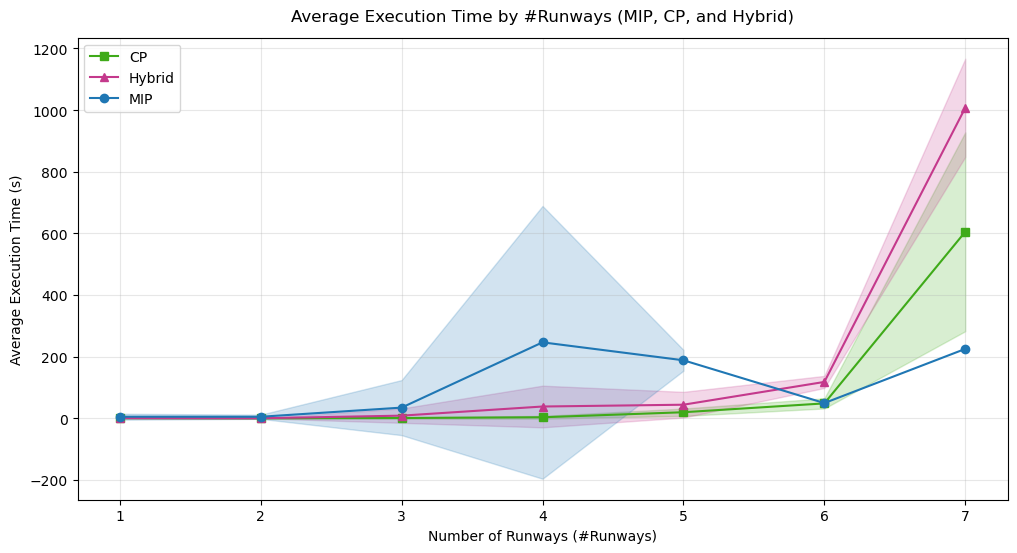

In [16]:
# Filter only solvers of interest and unify names
df_selected = df[df["Solver"].str.contains("MIP|CP|Hybrid")].copy()

df_selected["Solver"] = df_selected["Solver"].replace({
    "MIP Multiple Large Datasets": "MIP",
    "MIP Single": "MIP",
    "MIP Multiple": "MIP",
    "CP Multiple": "CP",
    "CP Single": "CP",
    "Hybrid Large Datasets": "Hybrid"
})

df_selected["#Planes"] = pd.to_numeric(df_selected["#Planes"])
df_selected["#Runways"] = pd.to_numeric(df_selected["#Runways"])

summary = df_selected.groupby(["Solver", "#Runways"]).agg(
    Time_mean=("Time (s)", "mean"),
    Time_std=("Time (s)", "std"),
    Penalty_mean=("Penalty / Obj", "mean"),
    Penalty_std=("Penalty / Obj", "std")
).reset_index()

# Plot mean Time ± standard deviation
plt.figure(figsize=(12, 6))
for solver in summary["Solver"].unique():
    data = summary[summary["Solver"] == solver]
    plt.plot(data["#Runways"], data["Time_mean"], marker=markers[solver], label=solver, color=solver_colors[solver])
    plt.fill_between(
        data["#Runways"],
        data["Time_mean"] - data["Time_std"],
        data["Time_mean"] + data["Time_std"],
        alpha=0.2,
        color=solver_colors[solver]
    )

plt.xlabel("Number of Runways (#Runways)")
plt.ylabel("Average Execution Time (s)")
plt.title("Average Execution Time by #Runways (MIP, CP, and Hybrid)")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
# Usa pivot_time já calculado
heat0 = pivot_time.copy()

# --- 1) Agrupar colunas por família (MIP / CP / Hybrid) ---
def family(c):
    c_up = str(c).upper()
    if "MIP" in c_up:
        return "MIP"
    if "CP" in c_up:
        return "CP"
    if "HYBRID" in c_up:
        return "Hybrid"
    return None  # ignora outras colunas, se existirem

families = pd.Series(heat0.columns, index=heat0.columns).map(family)

# fica só com as colunas das 3 famílias
heat0 = heat0.loc[:, families.notna()]
families = families.dropna()

# --- 2) Agregar por linha dentro de cada família ---
# escolhe a agregação: "median" (robusta) ou "min" (melhor tempo) ou "mean"
agg = "median"

if agg == "median":
    heat = heat0.groupby(families, axis=1).median(skipna=True)
elif agg == "min":
    heat = heat0.groupby(families, axis=1).min(skipna=True)
elif agg == "mean":
    heat = heat0.groupby(families, axis=1).mean(skipna=True)
else:
    raise ValueError("agg inválido")

# Garante ordem fixa das colunas
heat = heat.reindex(columns=["MIP", "CP", "Hybrid"])

# --- 3) Log e plot ---
heat_log = np.log10(heat.to_numpy(dtype=float) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heat_log, aspect="auto")

ax.set_title("Heatmap: log10(tempo) por instância vs família")
ax.set_xlabel("Família")
ax.set_ylabel("Instância (file | RW | cenário)")

ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels(heat.columns, rotation=0)

# ylabels: só algumas para não ficar ilegível
n = heat.shape[0]
step = max(1, n // 20)
yticks = np.arange(0, n, step)
ax.set_yticks(yticks)
ax.set_yticklabels([heat.index[i] for i in yticks])

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("log10(tempo em segundos)")

plt.tight_layout()
plt.show()


TypeError: GroupBy.median() got an unexpected keyword argument 'skipna'